# Using Image Classifier as Object Detectors

Here we will be using the HOG+SVM techniques to extract the information and regions from an image and then use a Image Classifier to classify the object in the proposed region.

Pipeline will look like:
- Region Proposal
    - Image Pyramid
    - Image Region proposal using sliding window
- Object Detection
    - Classification of object in a proposed Region
    - Collection of proposed regions which quialify a threshold
- Non Maximal Suppresion of similar regions
    - Intersection over Union of similar selected proposed regions
- Painiting bounding box on input for Object's Detected

# Notebook Configs

## Imports

In [1]:
import logging
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.applications import imagenet_utils

## Basic Settings

In [2]:
assert len(tf.config.experimental.list_physical_devices('GPU')) == 1

In [3]:
enable_info = True
if enable_info:
    logging.getLogger().setLevel(logging.INFO)

# Region Proposal

## Sliding Window

In [4]:
def slide_window(image, window_size, step):
    for y in range(0, image.shape[0] - window_size[0], step):
        for x in range(0, image.shape[1] - window_size[1], step):
            yield(x, y, image[y:y+window_size[0], x:x+window_size[1]])

## Image Pyramid

In [5]:
def image_pyramid(image, scale=1.5, min_size=(256, 256)):
    yield image
    while image.shape[0] >= min_size[0] and image.shape[1] >= min_size[1]:
        new_width = int(image.shape[0] / scale)
        new_height = int(image.shape[1] / scale)
        image = np.resize(image, (new_width, new_height, 3))
        yield image

# Object Detection

## Defining the Classifier

In [6]:
classifier = ResNet50(weights='imagenet', include_top=True)

## Image Preprocessing

In [8]:
img = cv2.imread('2.jpg')

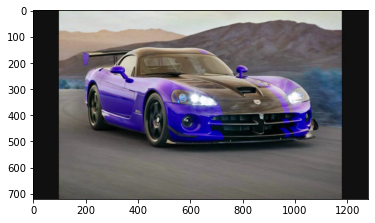

In [9]:
plt.imshow(img)
plt.show()

In [10]:
logging.info(img.shape)
logging.info('height: ' + str(img.shape[0]))
logging.info('width: ' + str(img.shape[1]))

INFO:root:(720, 1280, 3)
INFO:root:height: 720
INFO:root:width: 1280


In [11]:
logging.info(classifier.input)

INFO:root:Tensor("input_1:0", shape=(None, 224, 224, 3), dtype=float32)


## Generating regions

In [12]:
WINDOW_SIZE = (224, 224)
STEPS = 10
INPUT_IMAGE_SHAPE = img.shape

In [13]:
regions = []
locations = []
region_counter = 0
pyramid_counter = 0
img_pyramid = image_pyramid(img, scale = 1.5, min_size = WINDOW_SIZE)
for pyramid in img_pyramid:
    logging.info('pyramid '+ str(pyramid_counter))
    pyramid_counter +=1
    current_scale = INPUT_IMAGE_SHAPE[0] / pyramid.shape[0]
    window = slide_window(pyramid, WINDOW_SIZE, STEPS)
    for region_x, region_y, region in window:
        #logging.info(region_counter)
        region_counter +=1
        actual_x = int(region_x * current_scale)
        actual_y = int(region_y * current_scale)
        actual_width = int(region.shape[0] * current_scale)
        actual_height = int(region.shape[1] * current_scale)
        preprocess_img = preprocess_input(region)
        regions.append(preprocess_img)
        locations.append((actual_x, actual_y, actual_width, actual_height))

INFO:root:pyramid 0
INFO:root:pyramid 1
INFO:root:pyramid 2
INFO:root:pyramid 3


In [14]:
logging.info(len(regions))
logging.info(len(locations))
assert len(regions) == len(locations)

INFO:root:7288
INFO:root:7288


## Cross checking if all the regions are of input dimension or not

In [15]:
counter = 0
for r in regions:
    if r.shape != (224, 224, 3):
        logging.info(r.shape)
    counter +=1
logging.info(counter)

INFO:root:7288


## Sampling certain regions

In [16]:
import random

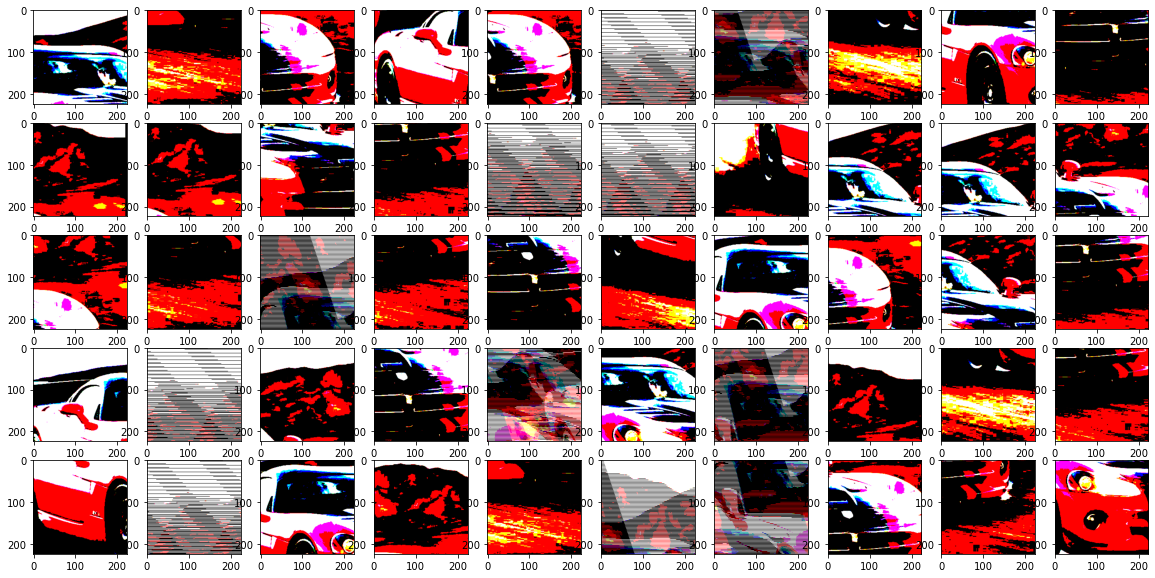

In [17]:
rows = 5
cols = 10
plt.figure(figsize=(20,10))
for i in range(rows):
    for j in range(cols):
        rand_index = random.randint(0, len(regions))
        plt.subplot(rows, cols, i*cols+j+1).imshow(regions[rand_index])
plt.show()

## Region Classification

In [18]:
r = np.array(regions)

In [19]:
predictions = classifier.predict(r, verbose=1)

228/228 [==============================] - 38s 166ms/step


In [20]:
decoded_predictions = imagenet_utils.decode_predictions(predictions, top=1)

In [21]:
len(decoded_predictions)

7288

In [29]:
decoded_predictions[30]

[('n02814533', 'beach_wagon', 0.20888326)]

## Thresholding Predictions

In [33]:
sports_car_pred = []
for i, pred in enumerate(decoded_predictions):
    if pred[0][1] == 'sports_car':
        sports_car_pred.append((i, pred))

In [35]:
len(sports_car_pred)

1925

In [101]:
threshold = 0.3
thresholded_predictions = []
for i, pred in sports_car_pred:
    if pred[0][2] > threshold:
        thresholded_predictions.append((i, pred))

In [102]:
len(thresholded_predictions)

1744

# Non Maximal Suppresion

In [103]:
thresholded_predictions[10]

(1020, [('n04285008', 'sports_car', 0.4459258)])

In [104]:
locations[1]

(10, 0, 224, 224)

In [114]:
iou_threshold = 0.3

In [115]:
# collection of index, area, coordinates, prediction-score
threshold_regions_nms = []
for pred in thresholded_predictions:
    loc = locations[pred[0]]
    area = abs((loc[3] - loc[1])*(loc[2] - loc[0]))
    threshold_regions_nms.append([pred[0], area, loc, pred[1][0][2]])

In [116]:
threshold_regions_nms[0]

[647, 18696, (110, 60, 224, 224), 0.31177393]

In [117]:
len(threshold_regions_nms)

1744

In [118]:
def iou(boxA, boxB):
    # intersection area
    x1 = max(boxA[0], boxB[0])
    y1 = min(boxA[1], boxB[1])
    x2 = min(boxA[2], boxB[2])
    y2 = max(boxA[3], boxB[3])
    
    area_intersection = abs((x1 - x2) * (y1 - y2))
    areaA = abs((boxA[0] - boxA[2]) * (boxA[1] - boxA[3]))
    areaB = abs((boxB[0] - boxB[2]) * (boxB[1] - boxB[3]))
    area_union = areaA + areaB - area_intersection
    
    iou_score = float(area_union) / float(area_intersection)
    return iou_score

In [119]:
final_regions = []
while len(threshold_regions_nms) > 2:
    # get the region with max score
    max_region = threshold_regions_nms[0]
    for region in threshold_regions_nms:
        if region[3] > max_region[3]:
            max_region = region
    final_regions.append(max_region)
    threshold_regions_nms.remove(max_region)
    for region in threshold_regions_nms:
        if iou(region[2], max_region[2]) > iou_threshold:
            threshold_regions_nms.remove(region)

In [120]:
len(final_regions)

13

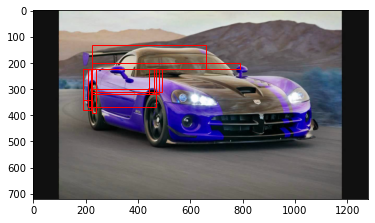

In [121]:
fig, ax = plt.subplots(1)
ax.imshow(img)
for region in final_regions:
    b = region[2]
    rec = patches.Rectangle((b[0], b[1]), b[2]-b[0], b[3]-b[1],linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rec)
plt.show()